In [159]:
# Julia Yaklin

import numpy as np
import math
import matplotlib.pyplot as plt

# Load data from npz file
my_data = np.load('A.npz')

bag_capacity = my_data['capacity']
n_items = my_data['n_items']
item_values = my_data['item_values']    
item_weights = my_data['item_weights']

SEED=124
rng = np.random.default_rng(SEED)

# initialize population (how is knapsack represented?)
# members of population are numbers of items (for 0/1 problem, 1 = corresponding item is included, 0 = corresponding item not included) 
POP_SIZE = 10

def calc_fitness(population):
    ''' fitness assignment '''
    fitness = population @ item_values # most basic fitness function
    weight = calc_weight(population)
    for i in range(len(fitness)): # piecewise fitness function w/ weight penalty
        if weight[i] > bag_capacity:
            fitness[i] = -weight[i] + 50
    
    return fitness

def calc_weight(population):
    ''' returns total weight of each member bag '''
    weight = population @ item_weights
    return weight

N_MATING = 5
def select_deterministic(population, pop_fitness):
    ''' return top N_MATING most fit members of population to mate and evaluate their fitness'''
    rank_indices = np.argsort(pop_fitness)
    parents = population[rank_indices][::-1][:N_MATING]
    return (parents, calc_fitness(parents))

N_OFFSPRING = math.comb(N_MATING, 2) // 2  # number of unique pairs of parents
CROSSOVER_INDEX = n_items // 2 # uniform crossover (always select same index)

def recombination(parents):
    ''' return offspring created by splitting parents at single index and recombining pairs and their fitness. '''
    offspring = np.empty(shape=(N_OFFSPRING, n_items))
    for i in range(N_OFFSPRING):
        parent_indices = rng.choice(range(N_MATING), size=2, replace=False) # parents never mate with themselves, so more solutions tested in same time
        parent1 = parents[parent_indices[0], :CROSSOVER_INDEX]
        parent2 = parents[parent_indices[1], CROSSOVER_INDEX:]
        
        offspring[i] = np.concatenate([parent1, parent2])
    return (offspring, calc_fitness(offspring))

PM = 0.1  # mutation rate parameter
def mutation(offspring):
    ''' return mutated offspring and their fitness.
        randomly re-roll elements in offspring with probability PM. '''
    mutated_offspring = offspring.copy()
    
    mask = rng.uniform(size=(N_OFFSPRING, n_items)) < PM
    drawn_values = rng.integers(0,1, size=(N_OFFSPRING,n_items), endpoint=True, dtype=int)
    mutated_offspring[mask] = drawn_values[mask]
    
    return (mutated_offspring, calc_fitness(mutated_offspring))

def hard_constraint(total_population): # naive constraint, delete solutions that exceed limit
    ''' scans the array for individual violating constraint bounds and chucks them out of processing.
        total_population includes all vectors (parents + mutated offsprings). '''
    modified_population = total_population.copy()
    
    mask = calc_weight(total_population) < bag_capacity
    modified_population = modified_population[mask]
    
    return modified_population

def environmental_selection(total_population):
    ''' calculate total population (after constraint checking) fitness,
        rank accoridingly and select only the top POP_SIZE individuals to pass on to the next generation ''' 
    fitness = calc_fitness(total_population)
    indices = np.argsort(fitness)[::-1][:POP_SIZE]
    return total_population[indices]  

In [160]:
import matplotlib.pyplot as plt

best_outputs = []
num_generations = 1000
curr_population = rng.uniform(size=(POP_SIZE,n_items)) < 0.5
overall_max_fitness = -99999
hard_constrained = False

# Run many iterations
# You should also have another convergence check
for generation in range(num_generations):
    print("Generation : ", generation)

    print("Current population")
    print(curr_population)

    print("Weight")
    print(calc_weight(curr_population))
    print(bag_capacity)
    # Measuring the fitness of each chromosome in the population.
    fitness = calc_fitness(curr_population)

    # print("Fitness")
    # print(fitness)

    max_fitness = np.max(fitness)

    # The best result in the current iteration.
    print("Best result in current iteration {0} compared to overall {1}".format(max_fitness, max(max_fitness, overall_max_fitness)))
    best_outputs.append(max_fitness)
    
    # Selecting the best parents in the population for mating.
    parents, _ = select_deterministic(curr_population, fitness)
#     parents, _ = select_stochastic(curr_population, fitness)
    
    # print("Parents")
    # print(parents)

    # Generating next generation using crossover.
    offspring_crossed, _ = recombination(parents)

    # print("Crossover")
    # print(offspring_crossed)

    # Adding some variations to the offspring using mutation.
    offspring_mutated, _ = mutation(offspring_crossed)

    # print("Mutation")
    # print(offspring_mutated)

    # Check for constraints
    total_population = np.vstack((curr_population, offspring_mutated))
    if hard_constrained:
        total_population = hard_constraint(total_population)

    # Environmental selection
    curr_population = environmental_selection(total_population)
              
# Getting the best solution after iterating finishing all generations.
#At first, the fitness is calculated for each solution in the final generation.
fitness = calc_fitness(curr_population)
weight = calc_weight(curr_population)

# Then return the index of that solution corresponding to the best fitness.
max_idx = np.argmax(fitness)

print("Best solution : ", curr_population[max_idx, :])
print("Best solution fitness : ", fitness[max_idx])
print("Best solution weight : ", weight[max_idx])

Generation :  0
Current population
[[False False False False False False  True False  True  True  True  True
  False  True False False False False  True  True False  True  True  True
   True  True  True  True False False  True False False  True False False
  False  True False False False False False  True False  True  True False
   True False]
 [ True  True False False  True False False False False False False  True
   True False  True  True  True  True False False  True False False False
  False  True False False False  True  True False  True  True  True  True
   True  True  True False False  True  True  True  True False  True  True
   True False]
 [ True False  True False False  True False  True  True  True False  True
   True False  True False False  True  True  True  True False False  True
   True False  True  True False False False  True  True  True False  True
  False False False False  True  True  True  True  True  True False False
   True  True]
 [ True  True  True False False 

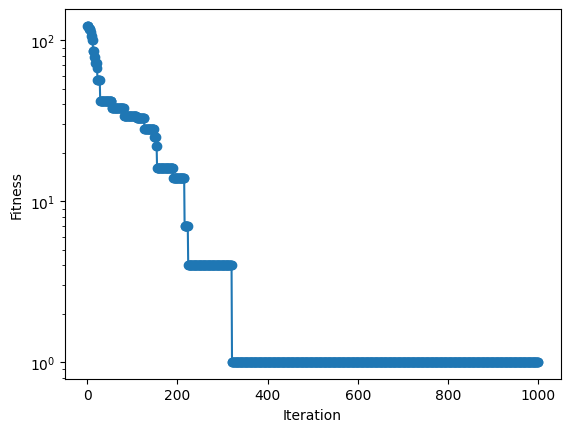

In [161]:
F_STAR = fitness[max_idx]+1
plt.figure()
plt.plot(F_STAR - np.array(best_outputs),'-o', label='from scratch')
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.yscale('log')
plt.show()